<a href="https://colab.research.google.com/github/NguyenVanVuong613/Finetune_SAM2/blob/main/Finetune_SAM2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/Segment_data.zip -d /content/new_data

In [ ]:
!git clone https://github.com/sagieppel/fine-tune-train_segment_anything_2_in_60_lines_of_code.git

In [4]:
%cd /content/fine-tune-train_segment_anything_2_in_60_lines_of_code

/content/fine-tune-train_segment_anything_2_in_60_lines_of_code


In [ ]:
!pip install hydra-core

In [ ]:
!pip install -e .

In [ ]:
!pip install --no-build-isolation -e .

In [ ]:
!python /content/fine-tune-train_segment_anything_2_in_60_lines_of_code/TRAIN.py

Train Code

In [ ]:
# Train/Fine-Tune SAM 2 on the LabPics 1 dataset

# Toturial: https://medium.com/@sagieppel/train-fine-tune-segment-anything-2-sam-2-in-60-lines-of-code-928dd29a63b3
# Main repo: https://github.com/facebookresearch/segment-anything-2
# Labpics Dataset can be downloaded from: https://zenodo.org/records/3697452/files/LabPicsV1.zip?download=1
# Pretrained models for sam2 Can be downloaded from: https://github.com/facebookresearch/segment-anything-2?tab=readme-ov-file#download-checkpoints

import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Read data

data_dir=r"//content//new_data//Segment_data//" # Path to dataset (LabPics 1)
data=[] # list of files in dataset
for ff, name in enumerate(os.listdir(data_dir+"image/")):  # go over all folder annotation
    data.append({"image":data_dir+"image/"+name,"annotation":data_dir+"instance/"+name[:-4]+".png"})


def read_batch(data): # read random image and its annotaion from  the dataset (LabPics)

   #  select image

        ent  = data[np.random.randint(len(data))] # choose random entry
        Img = cv2.imread(ent["image"])[...,::-1]  # read image
        ann_map = cv2.imread(ent["annotation"]) # read annotation

   # resize image

        r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scalling factor
        Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)

   # merge vessels and materials annotations

        hacto_map = ann_map[:,:,0] # material annotation map
        tebaoday_map = ann_map[:,:,1] # vessel  annotaion map
        tebaovay_map = ann_map[:,:,2]
        # Initialize combined map with class 1 values
        combined_map = np.copy(hacto_map)

# Update combined map with class 2 values where class 1 is not present
        combined_map[hacto_map == 0] = tebaoday_map[hacto_map == 0] + (hacto_map.max() + 1)

# Update combined map with class 3 values where class 1 and class 2 are not present
        combined_map[(combined_map == hacto_map.max() + 1) & (tebaoday_map != 0)] = tebaovay_map[(combined_map == hacto_map.max() + 1) & (tebaoday_map != 0)] + (tebaovay_map.max() + 1)


   # Get binary masks and points

        inds = np.unique(combined_map)[1:] # load all indices
        points= []
        masks = []
        for ind in inds:
            mask=(combined_map == ind).astype(np.uint8) # make binary mask corresponding to index ind
            masks.append(mask)
            coords = np.argwhere(mask > 0) # get all coordinates in mask
            yx = np.array(coords[np.random.randint(len(coords))]) # choose random point/coordinate
            points.append([[yx[1], yx[0]]])
        return Img,np.array(masks),np.array(points), np.ones([len(masks),1])

# Load model

sam2_checkpoint = "//content//drive//MyDrive//sam2_hiera_tiny.pt" # path to model weight (pre model loaded from: https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt)
model_cfg = "//content//fine-tune-train_segment_anything_2_in_60_lines_of_code//sam2_configs//sam2_hiera_t.yaml" #  model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model)

# Set training parameters

predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler() # mixed precision

# Training loop

for itr in range(20000):
    with torch.cuda.amp.autocast(): # cast to mix precision
            image,mask,input_point, input_label = read_batch(data) # load data batch
            if mask.shape[0]==0: continue # ignore empty batches
            predictor.set_image(image) # apply SAM image encoder to the image

            # prompt encoding

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)

            # mask decoder

            batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution

            # Segmentaion Loss caclulation

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])# Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss

            # Score loss calculation (intersection over union) IOU

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss=seg_loss+score_loss*0.05  # mix losses

            # apply back propogation

            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision

            if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch");print("save model")

            # Display results

            if itr==0: mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            print("step)",itr, "Accuracy(IOU)=",mean_iou)



Test Code

/content/fine-tune-train_segment_anything_2_in_60_lines_of_code/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


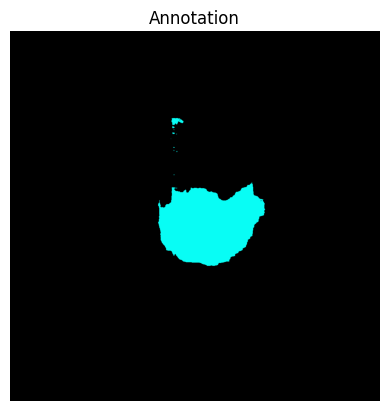

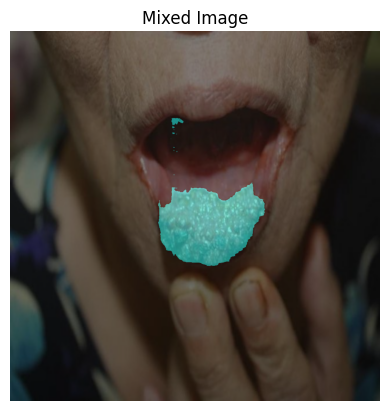

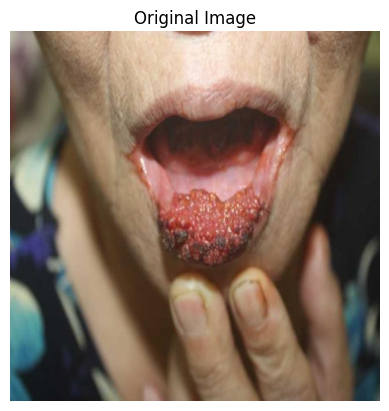

In [17]:
# segment image region using  fine tune model
# See Train.py on how to fine tune/train the model
import numpy as np
import torch
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

# Load image

image_path = r"//content//new_data//Segment_data//image//image_uuid_001c7428-2457-46aa-9ec8-51db50ad4f50_created_by_PhanNuThucHien_7HmAlG5_jpeg.rf.f99e08688d5ad2841da79ea3b9c4c349.jpg" # path to image
mask_path = r"//content//new_data//Segment_data//instance//image_uuid_001c7428-2457-46aa-9ec8-51db50ad4f50_created_by_PhanNuThucHien_7HmAlG5_jpeg.rf.f99e08688d5ad2841da79ea3b9c4c349.png" # path to mask, the mask will define the image region to segment

def read_image(image_path, mask_path): # read and resize image and mask
        img = cv2.imread(image_path)[...,::-1]  # read image as rgb
        mask = cv2.imread(mask_path,0) # mask of the region we want to segment

        # Resize image to maximum size of 1024

        r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
        img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
        mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
        return img, mask
image,mask = read_image(image_path, mask_path)
num_samples = 30 # number of points/segment to sample
def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)
input_points = get_points(mask,num_samples)
# read image and sample points


# Load model you need to have pretrained model already made
sam2_checkpoint = "/content/drive/MyDrive/sam2_hiera_tiny.pt" # "sam2_hiera_large.pt"
model_cfg = "//content//fine-tune-train_segment_anything_2_in_60_lines_of_code//sam2_configs//sam2_hiera_t.yaml" # "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("//content//fine-tune-train_segment_anything_2_in_60_lines_of_code//model.torch"))

# predict mask

with torch.no_grad():
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=np.ones([input_points.shape[0],1])
        )

# Short predicted masks from high to low score

masks=masks[:,0].astype(bool)
shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)

# Stitch predicted mask into one segmentation mask

seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)
for i in range(shorted_masks.shape[0]):
    mask = shorted_masks[i]
    if (mask*occupancy_mask).sum()/mask.sum()>0.15: continue
    mask[occupancy_mask]=0
    seg_map[mask]=i+1
    occupancy_mask[mask]=1

# create colored annotation map
height, width = seg_map.shape

# Create an empty RGB image for the colored annotation
rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
for id_class in range(1,seg_map.max()+1):
    rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

# save and display

cv2.imwrite("annotation.png",rgb_image)
cv2.imwrite("mix.png",(rgb_image/2+image/2).astype(np.uint8))

# Display images using matplotlib (suitable for Jupyter notebooks or Colab)
import matplotlib.pyplot as plt

# Display the annotation image
plt.imshow(rgb_image)
plt.title('Annotation')
plt.axis('off')
plt.show()

# Display the mixed image
plt.imshow((rgb_image / 2 + image / 2).astype(np.uint8))
plt.title('Mixed Image')
plt.axis('off')
plt.show()

# Display the original image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()
